In [1]:
# https://medium.com/@sonicboom8/sentiment-analysis-with-variable-length-sequences-in-pytorch-6241635ae130

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('data/sentiment-analysis.csv', error_bad_lines=False)

b'Skipping line 8836: expected 4 fields, saw 5\n'
b'Skipping line 535882: expected 4 fields, saw 7\n'


In [4]:
df.head()

,ItemID,Sentiment,SentimentSource,SentimentText
0,1,0,Sentiment140,is so sad for my APL frie...
1,2,0,Sentiment140,I missed the New Moon trail...
2,3,1,Sentiment140,omg its already 7:30 :O
3,4,0,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,Sentiment140,i think mi bf is cheating on me!!! ...


In [5]:
import spacy
from tqdm import tqdm, tqdm_notebook, tnrange

In [6]:
nlp = spacy.load('en', disable=['parser', 'tagger', 'ner'])

In [7]:
df['SentimentText'] = tqdm(df['SentimentText'].apply(lambda x: x.strip()))

100%|██████████| 1578612/1578612 [00:00<00:00, 2426927.88it/s]


In [8]:
from collections import Counter

In [9]:
words = Counter()
for sentence in tqdm(df.SentimentText.values):
    words.update(w.text.lower() for w in nlp(sentence))

100%|██████████| 1578612/1578612 [04:22<00:00, 6021.66it/s]


In [10]:
len(words)

773040

In [11]:
words = sorted(words, key=words.get, reverse=True)

In [12]:
words = ['_PAD','_UNK'] + words

In [13]:
word2idx = {o:i for i,o in enumerate(words)}
idx2word = {i:o for i,o in enumerate(words)}

In [14]:
import pickle

In [15]:
pickle.dump(word2idx, open('binary/word2idx.pkl', 'wb'), pickle.HIGHEST_PROTOCOL)

In [16]:
pickle.dump(idx2word, open('binary/idx2word.pkl', 'wb'), pickle.HIGHEST_PROTOCOL)

In [17]:
def indexer(s): 
    return [word2idx[w.text.lower()] for w in nlp(s)]

In [18]:
df['sentimentidx'] = df.SentimentText.apply(indexer)

In [19]:
df['lengths'] = df.sentimentidx.apply(lambda x: 16 if len(x) > 16 else len(x))

In [20]:
def pad_data(s):
        padded = np.zeros((16,), dtype=np.int64)
        if len(s) > 16: padded[:] = s[:16]
        else: padded[:len(s)] = s
        return padded

In [21]:
df['sentimentpadded'] = df.sentimentidx.apply(pad_data)

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


[Text(0,0.5,'Frequency'), Text(0.5,0,'Tweet Length')]

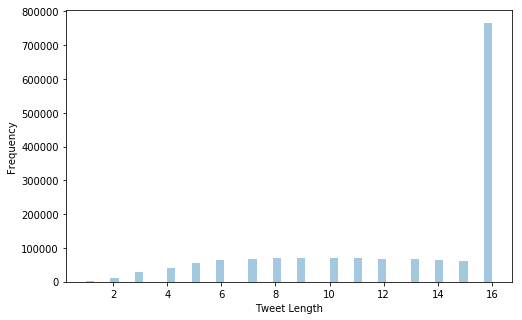

In [22]:
fig = plt.figure(figsize=(8,5))
ax = sns.distplot(df.lengths.values,kde=False);
ax.set(xlabel='Tweet Length', ylabel='Frequency')

In [23]:
df.head()

,ItemID,Sentiment,SentimentSource,SentimentText,sentimentidx,lengths,sentimentpadded
0,1,0,Sentiment140,is so sad for my APL friend.............,"[14, 26, 132, 18, 10, 241549, 266, 6621]",8,"[14, 26, 132, 18, 10, 241549, 266, 6621, 0, 0,..."
1,2,0,Sentiment140,I missed the New Moon trailer...,"[2, 272, 7, 90, 812, 1274, 16]",7,"[2, 272, 7, 90, 812, 1274, 16, 0, 0, 0, 0, 0, ..."
2,3,1,Sentiment140,omg its already 7:30 :O,"[247, 82, 217, 4573, 1012]",5,"[247, 82, 217, 4573, 1012, 0, 0, 0, 0, 0, 0, 0..."
3,4,0,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I've been at...,"[37, 241550, 4, 2, 73, 440, 6, 2, 73, 1454, 55...",16,"[37, 241550, 4, 2, 73, 440, 6, 2, 73, 1454, 55..."
4,5,0,Sentiment140,i think mi bf is cheating on me!!! T_T,"[2, 93, 1815, 1342, 14, 5521, 23, 24, 3, 3, 3,...",13,"[2, 93, 1815, 1342, 14, 5521, 23, 24, 3, 3, 3,..."


In [24]:
df.to_csv('data/sentiment-analysis-prepared.csv')

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable

In [149]:
class VectorizeData(Dataset):
    def __init__(self, df_path, max_len=10):
        self.max_len = max_len
        self.df = pd.read_csv(df_path, error_bad_lines=False)
        self.df['SentimentText'] = self.df.SentimentText.apply(lambda x: x.strip())
        self.df['sentimentidx'] = self.df.SentimentText.apply(indexer)
        self.df['lengths'] = self.df.sentimentidx.apply(lambda x: self.max_len if len(x) > self.max_len else len(x))
        self.df['sentimentpadded'] = self.df.sentimentidx.apply(pad_data)
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        X = self.df.sentimentpadded[idx]
        lens = self.df.lengths[idx]
        y = self.df.Sentiment[idx]
        return X, y, lens

In [150]:
dataset = VectorizeData('data/sentiment-analysis.csv')

b'Skipping line 8836: expected 4 fields, saw 5\n'
b'Skipping line 535882: expected 4 fields, saw 7\n'


In [151]:
print(dataset[:5])

(0    [14, 26, 132, 18, 10, 241549, 266, 6621, 0, 0,...
1    [2, 272, 7, 90, 812, 1274, 16, 0, 0, 0, 0, 0, ...
2    [247, 82, 217, 4573, 1012, 0, 0, 0, 0, 0, 0, 0...
3    [37, 241550, 4, 2, 73, 440, 6, 2, 73, 1454, 55...
4    [2, 93, 1815, 1342, 14, 5521, 23, 24, 3, 3, 3,...
Name: sentimentpadded, dtype: object, 0    0
1    0
2    1
3    0
4    0
Name: Sentiment, dtype: int64, 0     8
1     7
2     5
3    10
4    10
Name: lengths, dtype: int64)


In [152]:
vocabulary_size = len(words)
embedding_dimension = 32
num_hidden = 32
num_out = 2

In [189]:
class TestGRU(nn.Module):
    def __init__(self, vocabulary_size, embedding_dimension, num_hidden, num_out):
        super().__init__()
        
        self.vocabulary_size, self.embedding_dimension, self.num_hidden, self.num_out = \
                                vocabulary_size, embedding_dimension, num_hidden, num_out
        
        self.embedding = nn.Embedding(self.vocabulary_size, self.embedding_dimension)
        self.gru = nn.GRU(self.embedding_dimension, self.num_hidden)
        self.out = nn.Linear(self.num_hidden, self.num_out)
        
    def forward(self, sequence, lengths):
        batch_size = sequence.size(1) 

        self.h = self.init_hidden(batch_size)

        embeddings = self.embedding(sequence)
        embeddings = pack_padded_sequence(embeddings, lengths) 
        
        gru_out, self.h = self.gru(embeddings, self.h)
        gru_out, lengths = pad_packed_sequence(gru_out)
        
        output = self.out(self.h[-1])
        return F.log_softmax(output, dim=-1)
    
    def init_hidden(self, batch_size):
        return Variable(torch.zeros((1, batch_size, self.num_hidden)))

In [190]:
test_gru = TestGRU(vocabulary_size, embedding_dimension, num_hidden, num_out)

In [191]:
test_gru

TestGRU(
  (embedding): Embedding(773042, 32)
  (gru): GRU(32, 32)
  (out): Linear(in_features=32, out_features=2, bias=True)
)

In [192]:
def sort_batch(X, y, lengths):
    lengths, idx = lengths.sort(dim=0, descending=True)
    
    X = X[idx]
    y = y[idx]
    
    return X.transpose(0,1), y, lengths 

In [193]:
dataloader = DataLoader(dataset=dataset, batch_size=16) 

In [194]:
print('Total samples', len(dataloader))

Total samples 98664


In [195]:
iterator = iter(dataloader)

In [196]:
xs, ys, lens =  next(iterator)

In [197]:
xs[0]

tensor([ 1.4000e+01,  2.6000e+01,  1.3200e+02,  1.8000e+01,  1.0000e+01,
         2.4155e+05,  2.6600e+02,  6.6210e+03,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00])

In [198]:
print(lens.sort(dim=0, descending=True))

(tensor([ 10,  10,  10,  10,  10,  10,  10,   9,   8,   7,   7,   7,
          6,   6,   5,   4]), tensor([  8,   7,  11,   9,  15,   4,   3,  13,   0,  14,   5,   1,
         12,  10,   2,   6]))


In [199]:
xs, ys, lens = sort_batch(xs, ys, lens)

In [200]:
outputs = test_gru(xs, lens.cpu().numpy())

In [201]:
outputs

tensor([[-0.6764, -0.7102],
        [-1.0052, -0.4557],
        [-0.6076, -0.7867],
        [-0.6407, -0.7485],
        [-0.8402, -0.5650],
        [-0.7919, -0.6033],
        [-0.6016, -0.7940],
        [-0.6979, -0.6884],
        [-0.8093, -0.5891],
        [-0.8251, -0.5766],
        [-0.6350, -0.7549],
        [-0.4465, -1.0213],
        [-0.6437, -0.7451],
        [-0.6063, -0.7883],
        [-0.6381, -0.7514],
        [-0.6886, -0.6977]])

In [202]:
torch.max(outputs, dim=1)

(tensor([-0.6764, -0.4557, -0.6076, -0.6407, -0.5650, -0.6033, -0.6016,
         -0.6884, -0.5891, -0.5766, -0.6350, -0.4465, -0.6437, -0.6063,
         -0.6381, -0.6886]),
 tensor([ 0,  1,  0,  0,  1,  1,  0,  1,  1,  1,  0,  0,  0,  0,
          0,  0]))